In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

In [3]:
# compare histogram of pixel avg for train vs adversarial

In [4]:
train_data_path = 'DEEPSAT6/X_train_sat6.csv'
train_label_path = 'DEEPSAT6/y_train_sat6.csv'
test_data_path = 'DEEPSAT6/X_test_sat6.csv'
test_label_path = 'DEEPSAT6/y_test_sat6.csv'

In [5]:
x_train = pd.read_csv(train_data_path, header=None, dtype='uint8')
y_train = pd.read_csv(train_label_path, header=None, dtype='uint8')
x_test = pd.read_csv(test_data_path, header=None, dtype='uint8')
y_test = pd.read_csv(test_label_path, header=None, dtype='uint8')

In [6]:
print("Train data shape: ", x_train.shape)
print("Train label shape: ", y_train.shape)
print("Test data shape: ", x_test.shape)
print("Test label shape: ", y_test.shape)

Train data shape:  (324000, 3136)
Train label shape:  (324000, 6)
Test data shape:  (81000, 3136)
Test label shape:  (81000, 6)


In [7]:
x_train = x_train.values.reshape([-1,28,28,4])
x_test = x_test.values.reshape([-1,28,28,4])

x_train.shape, x_test.shape

((324000, 28, 28, 4), (81000, 28, 28, 4))

In [8]:
class_names = ['Construction', 'Road', 'Grassland', 'Barren', 'Water', 'Treecover']
class_count = len(class_names)

print("Num. classes: %d" % class_count)
print("Class names:", class_names)

Num. classes: 6
Class names: ['Construction', 'Road', 'Grassland', 'Barren', 'Water', 'Treecover']


In [9]:
def label_converter(values):
  if values[0] == 1:    # Building 
    return 0
  elif values[1] == 1:  # Barren land 
    return 3
  elif values[2] == 1:  # Trees
    return 5
  elif values[3] == 1:  # Grassland
    return 2
  elif values[4] == 1:  # Road
    return 1
  elif values[5] == 1:  # Water
    return 4
  else:
    return None

In [10]:
y_train = y_train.apply(label_converter, axis=1).values.ravel().astype('uint8')
#y_train = train_label.values.ravel().astype('uint8')
#y_train = train_label.apply(label_converter, axis=1).astype('category')
y_train

array([5, 3, 4, ..., 4, 2, 3], dtype=uint8)

In [11]:
y_test = y_test.apply(label_converter, axis=1).values.ravel().astype('uint8')
#y_test = test_label.values.ravel().astype('uint8')
#y_test = test_label.apply(label_converter, axis=1).astype('category')
y_test

array([5, 5, 4, ..., 5, 4, 5], dtype=uint8)

In [12]:
np.unique(y_train, return_counts=True)
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=uint8),
 array([ 3714,  2070, 12596, 18367, 30068, 14185], dtype=int64))

In [13]:
def show_samples(data, labels):
    fig = plt.figure(figsize=(16, 8))
    ax = []
    rows, columns = 4, 8
    
    for i in range(columns * rows):
        index = np.random.randint(1, 500)
        img = data[index].reshape([28,28,4])[:,:,:3]
        class_name = class_names[labels[index]]
        ax.append(fig.add_subplot(rows, columns, i+1))
        ax[-1].set_title(class_name)
        plt.axis("off")
        plt.imshow(img)

    plt.subplots_adjust(wspace=0.1, hspace=0.5)
    plt.show()

In [14]:
# show_samples(x_train, y_train) <---- BROKEN with dtype tf.float32

In [15]:
def show_sample_histogram(data, labels, index=None):

    if not index:
        index = np.random.randint(1, len(labels))

    fig = plt.figure(figsize=(12, 6))
    ax = []
    rows, columns = 1, 2
    colors = ("red", "green", "blue", "purple")
    channel_ids = (0, 1, 2, 3)

    all = data[index].reshape([28, 28, 4])

    class_name = class_names[labels[index]]
    rgb = all[:,:,:3]
    ax.append(fig.add_subplot(rows, columns, 1))
    ax[-1].set_title(class_name, fontsize=20)
    plt.axis("off")
    plt.imshow(rgb)

    ax.append(fig.add_subplot(rows, columns, 2))
    ax[-1].set_xlim([0, 256])
    for channel_id, c in zip(channel_ids, colors):
        histogram, bin_edges = np.histogram(
            all[:, :, channel_id], bins=256, range=(0, 256))
        ax[-1].plot(bin_edges[0:-1], histogram, color=c, linewidth=0.8)
        ax[-1].set_title('Histogram of pixels', fontsize=20)
        ax[-1].legend(['R', 'G', 'B', 'NIR'])

    fig.tight_layout()

    #plt.subplots_adjust(wspace=0.1, hspace=0.5)
    plt.show()

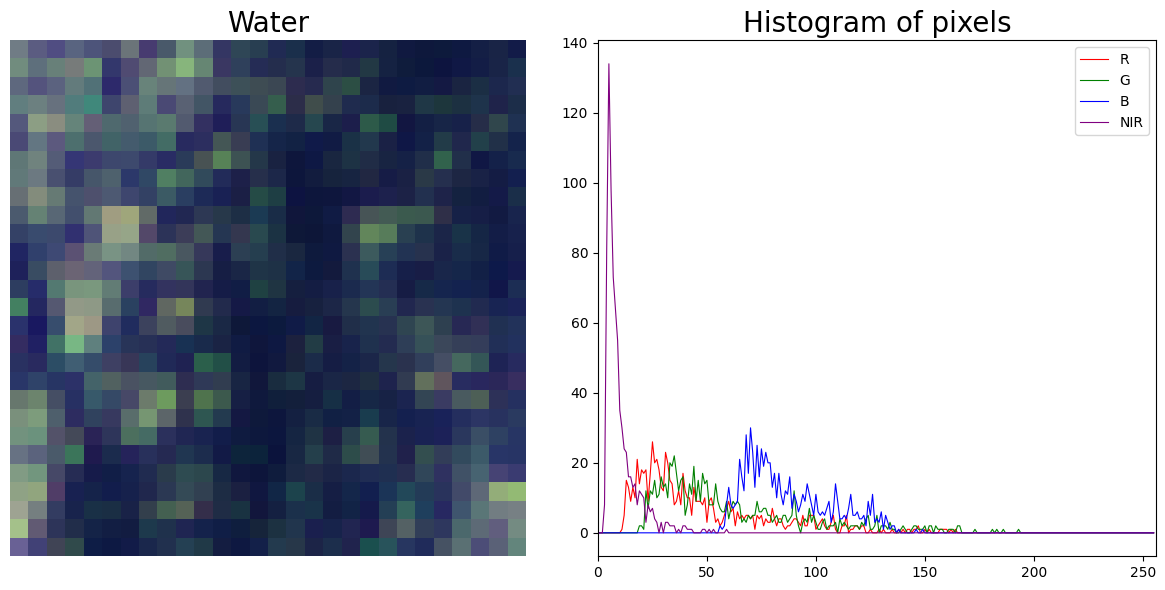

In [16]:
show_sample_histogram(x_train, y_train) #index = n

In [17]:
x_train_partial, x_validation, y_train_partial, y_validation = train_test_split(
    x_train, y_train, test_size=0.3, random_state=0, stratify=y_train)

print(x_train_partial.shape)
print(x_validation.shape)
print(y_train_partial.shape)
print(y_validation.shape)

(226800, 28, 28, 4)
(97200, 28, 28, 4)
(226800,)
(97200,)


In [18]:
def train_and_test(id, model, x_train, y_train, x_test, y_test, epochs=10): 
    global best_model, best_accuracy

    start_time = datetime.now()
    model.fit(x_train, y_train, epochs=epochs)

    end_time = datetime.now()
    duration = (end_time - start_time).total_seconds()

    print("Training took %.1f seconds" % duration)
    
    print(f"Model eval:")
    accuracy = model.evaluate(x_test, y_test)

    #benchmark[id] = (accuracy[1], accuracy[0], duration)

    #if accuracy[1] > best_accuracy:
    #    best_model = model
    #    best_accuracy = accuracy[1]

    return accuracy

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [20]:
def create_modelv1(class_count, print_summary=False):

    model = Sequential([
        Conv2D(32, (4,4), activation='relu', input_shape=(28,28,4)),
        MaxPool2D((3,3)),
        Flatten(),
        Dense(class_count, activation='softmax'),
    ])

    model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    if print_summary:
        model.summary()

    return model

In [21]:
seed_value = 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

In [22]:
epsilon=0.1
x_test_lim = x_test[:500]
y_test_lim = y_test[:500]
x_train_lim = x_train[:500]
y_train_lim = y_train[:500]

In [23]:
modelv1 = create_modelv1(class_count)
train_and_test('v0.1', modelv1, x_train, y_train, x_test, y_test, epochs=3)

c:\Users\Durf\anaconda3\envs\tools1\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
10125/10125 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.8568 - loss: 0.6981
Epoch 2/3
10125/10125 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.8908 - loss: 0.3391
Epoch 3/3
10125/10125 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9036 - loss: 0.3093
Training took 97.4 seconds
Model eval:
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8880 - loss: 0.3439


[0.34060919284820557, 0.8881481289863586]

In [24]:
modelv1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 25, 25, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        12,294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,124 (168.46 KB)

 Trainable params: 14,374 (56.15 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 28,750 (112.31 KB)

In [25]:
def fgsm_attack(model, images, labels, epsilon):
    # Enable gradient tape for automatic differentiation
    with tf.GradientTape() as tape:
        # Cast images to float32 if they are not already
        images = tf.convert_to_tensor(images, dtype=tf.float32)
        # Make the model predictions
        tape.watch(images)
        predictions = model(images, training=True)
        # print(predictions)
        # Calculate the loss
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
        loss = tf.reduce_mean(loss)
        print(loss)

    # Calculate gradients of the loss with respect to the input image
    gradients = tape.gradient(loss, images)

    if gradients is None:
        raise ValueError('NO GRAD')
    # print(gradients)
    # Get the sign of the gradients
    signed_gradients = tf.sign(gradients)
    # Create the adversarial images
    adversarial_images = images + epsilon * signed_gradients
    # Clip the values to maintain valid pixel range
    adversarial_images = tf.clip_by_value(adversarial_images, 0, 1)  # Adjust based on normalization

    return adversarial_images

In [26]:
adversarial_images = fgsm_attack(modelv1, x_test_lim, y_test_lim, epsilon)

tf.Tensor(0.38633388, shape=(), dtype=float32)


In [27]:
loss,accuracy = modelv1.evaluate(adversarial_images, y_train)
print(f"Adversarial acc: {accuracy}")

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 500
'y' sizes: 324000


In [ ]:
# # Custom training loop
# for epoch in range(num_epochs):
#     for images, labels in train_dataset:  # Assuming you have a training dataset
#         # Generate adversarial examples
#         adversarial_images = fgsm_attack(model, images, labels, epsilon)

#         # Combine clean and adversarial images for training (if desired)
#         combined_images = tf.concat([images, adversarial_images], axis=0)
#         combined_labels = tf.concat([labels, labels], axis=0)  # Repeat labels

#         # Train the model
#         model.train_on_batch(combined_images, combined_labels)